## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [11]:
!pip install -r requirements.txt

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [12]:
#Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [13]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# === 1. Food Expenditures ===
#x = read_sheets(Senegal_Data, sheet='Food Expenditures (2019)')
x = pd.read_csv("Food_Expenditures_T(2019).csv", header= 0, index_col=0)
x = x.set_index(['i', 't', 'm', 'j']).squeeze()

# === 2. Food Prices ===
#p = read_sheets(Senegal_Data, sheet='Food Prices (2019)').set_index(['t', 'm', 'j', 'u'])
p = pd.read_csv('Food_Prices_T(2019).csv', header= 0).set_index(['t', 'm', 'j', 'u'])
p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

# Compute medians of prices for each (t, m, j, u)
p = p.groupby(['t', 'm', 'j', 'u']).median()

# Keep only Kg unit
p = p.xs('Kg', level="u").squeeze().unstack('j')

# Find intersection of goods between price data and expenditure data
common_goods = list(set(p.columns).intersection(set(x.index.get_level_values('j'))))

# Filter both datasets to those goods
p = p[common_goods].T

# === 3. Household Characteristics ===
#d = read_sheets(Senegal_Data, sheet='Household Characteristics')
d = pd.read_csv('Household_Characteristics.csv', header= 0)
d.columns.name = 'k'

# Replace blanks with zeros
d = d.replace(np.nan, 0)

# Group expenditures and clean
x = x.T.groupby(['i', 't', 'm', 'j']).sum()
x = x.replace(0, np.nan)

# Take logs of expenditures
y = np.log(x)

# Set index for household characteristics
d.set_index(['i', 't', 'm'], inplace=True)
d = d.drop(columns=["Unnamed: 0"])

This gives a dataframe of household characteristics $d$ with a simple structure.



In [14]:
d.head()

,,k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [15]:
y.head()

i    t     m      j                           
221  2019  dakar  Beef                            8.006368
                  Cabbage                         4.605170
                  Caramel, candy, sweets, etc.    5.703782
                  Carrot                          4.605170
                  Cassava                         4.605170
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [16]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [17]:
result.predicted_expenditures()

i       t     m        j                                  
221     2019  dakar    Baobab leaves (lalo)                    107.077774
                       Beef                                   3490.727220
                       Bouillon cubes (Maggi, Jumbo, etc.)      99.763717
                       Butter                                  405.592457
                       Cabbage                                 229.066960
                                                                 ...     
259812  2019  sedhiou  Sweet banana                            270.855451
                       Sweet potato                            127.259450
                       Tea                                     145.806029
                       Tomato paste                            128.557033
                       Vinegar/mustard                         144.368164
Length: 178980, dtype: float64

Now we can compare predicted log expenditures with actual:



y      yhat
i      t    m       j                                                      
221    2019 dakar   Baobab leaves (lalo)                      NaN  4.620843
                    Beef                                 8.006368  8.015458
                    Bouillon cubes (Maggi, Jumbo, etc.)       NaN  4.386137
                    Butter                                    NaN  5.472972
                    Cabbage                              4.605170  5.234584
...                                                           ...       ...
259812 2019 sedhiou Sweet banana                              NaN  5.437278
                    Sweet potato                              NaN  4.739290
                    Tea                                  4.605170  4.952530
                    Tomato paste                         4.605170  4.774056
                    Vinegar/mustard                           NaN  4.351275

[192537 rows x 2 columns]

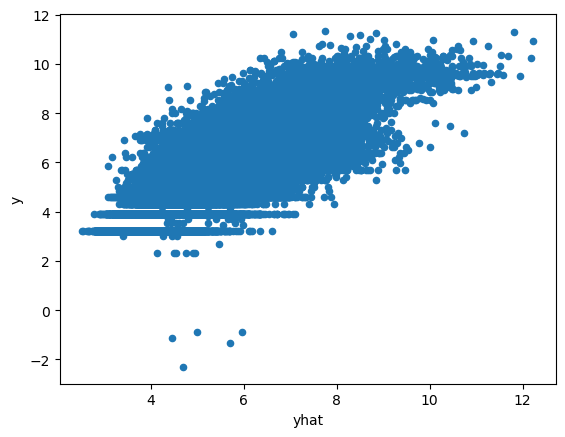

In [18]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



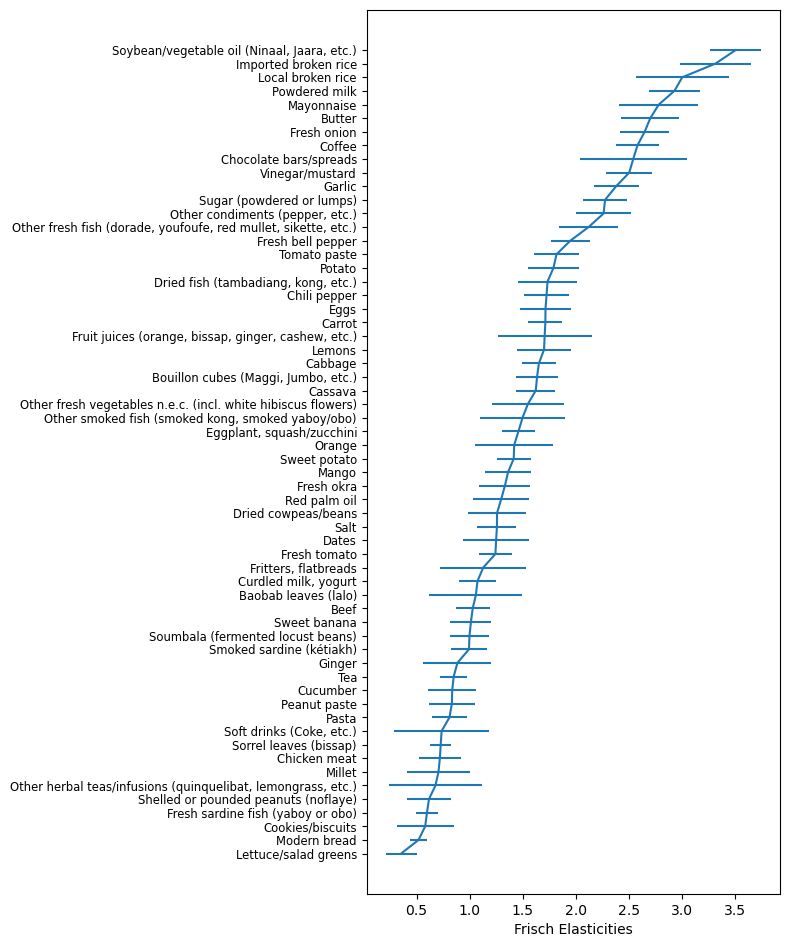

In [19]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [20]:
result.get_beta()

j
Baobab leaves (lalo)                                              1.058982
Beef                                                              1.028680
Bouillon cubes (Maggi, Jumbo, etc.)                               1.634301
Butter                                                            2.700641
Cabbage                                                           1.651856
Carrot                                                            1.712786
Cassava                                                           1.622657
Chicken meat                                                      0.719736
Chili pepper                                                      1.723880
Chocolate bars/spreads                                            2.539853
Coffee                                                            2.579637
Cookies/biscuits                                                  0.581559
Cucumber                                                          0.835879
Curdled milk, yogurt   

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [21]:
result.get_gamma()

k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Baobab leaves (lalo),0.156074,-0.057738,0.119829,0.094122,-0.086734,0.101469,-0.059864,0.154715,-0.113262,0.109330,-0.084765,0.006962,-0.100032,-0.225432,-0.136988,-0.034275,0.028048,-0.010040,-0.143442,4.369526
Beef,0.010973,0.014437,0.007809,0.024193,-0.021695,-0.053174,-0.020634,-0.016997,-0.048001,-0.023625,0.003684,-0.024899,-0.005145,0.039727,0.036322,0.070613,0.092687,0.041588,0.066584,7.779694
"Bouillon cubes (Maggi, Jumbo, etc.)",0.958984,0.927342,-1.023663,-0.980848,1.067919,-0.886174,1.066054,-0.891818,1.021297,-0.903698,1.018609,-0.941900,1.004503,-0.917992,0.983742,-0.859130,1.014270,-0.838386,-0.093550,4.210996
Butter,-1.402476,-1.662605,-0.140015,0.130126,0.083617,1.632537,0.211181,1.701425,0.080176,1.655177,0.081098,1.599504,-0.167640,1.497435,-0.141060,1.483881,-0.153448,1.404416,0.149140,5.687287
Cabbage,1.485759,1.486260,-0.352361,-0.306158,0.354626,-1.475321,0.391012,-1.452646,0.335833,-1.485062,0.353762,-1.515886,0.361270,-1.410473,0.366828,-1.380613,0.405595,-1.412818,-0.076593,4.922622
Carrot,0.618248,0.593989,0.283169,0.366963,-0.315915,-0.576286,-0.245842,-0.589391,-0.298192,-0.618458,-0.307775,-0.633711,-0.335800,-0.540435,-0.323490,-0.526013,-0.274481,-0.550336,0.008994,4.758860
Cassava,0.080532,0.093253,-0.006438,0.057661,0.026182,-0.067455,0.011889,-0.106609,0.015078,-0.062739,-0.025121,-0.118587,-0.015486,-0.042957,0.005558,-0.033929,0.036303,-0.031614,0.058022,4.743869
Chicken meat,0.077530,-0.028237,0.041276,0.043545,0.017243,0.029811,-0.002910,0.072221,-0.098405,0.057924,-0.008123,0.036860,-0.006286,-0.068724,0.027360,-0.023436,0.161462,-0.047081,-0.047947,8.235288
Chili pepper,0.694366,0.685694,0.309956,0.386236,-0.319233,-0.703148,-0.278245,-0.662633,-0.348457,-0.695711,-0.302989,-0.708394,-0.343661,-0.626054,-0.352262,-0.614427,-0.380048,-0.652160,-0.052743,4.079933


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

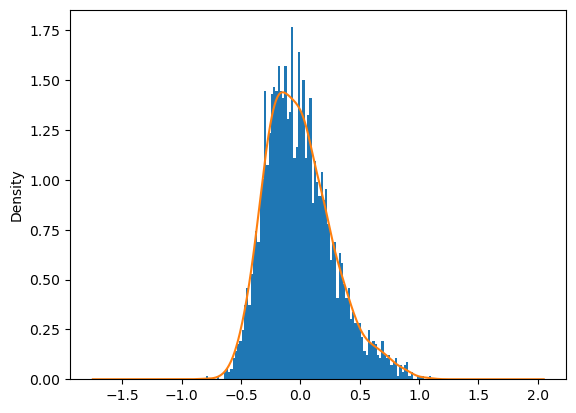

In [22]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [23]:
# Save the regression result
result.to_pickle('senegal_estimates.rgsn')

You can subsequently load this using



In [24]:
import cfe
result = cfe.regression.read_pickle('senegal_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [25]:
import numpy as np

# Get predicted expenditures
xhat = result.predicted_expenditures()

# Total food expenditures per household (i, t, m)
xbar = xhat.groupby(['i', 't', 'm']).sum()

# Reference budget: median household's budget
xref = xbar.quantile(0.5)  # 50th percentile

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [26]:
# Step 1: Average prices across markets
pbar = p.mean(axis=1)  # average over markets (axis=1)

# Step 2: Keep only goods that exist in both price data and estimated betas
estimated_goods = result.beta.index             # goods estimated by the model
available_goods = pbar.index                    # goods for which we have price data
common_goods = estimated_goods.intersection(available_goods)  # safe intersection
pbar = pbar.loc[common_goods]

# Step 3: Replace any missing values with 1 (for stability in simulations)
pbar = pbar.replace(np.nan, 1)

def my_prices(p0, j, p=pbar):
    """
    Change price of j-th good to p0, holding other prices fixed.
    
    Parameters:
    p0: new price to set
    j:  name of the good (string)
    p:  reference price vector (default: pbar)
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [27]:
pbar.head()

j
Baobab leaves (lalo)    1658.333313
Beef                    2550.000000
Butter                  1600.000000
Cabbage                  500.000000
Carrot                   433.928571
dtype: float64

Available goods: ['Baobab leaves (lalo)', 'Beef', 'Bouillon cubes (Maggi, Jumbo, etc.)', 'Butter', 'Cabbage', 'Carrot', 'Cassava', 'Chicken meat', 'Chili pepper', 'Chocolate bars/spreads', 'Coffee', 'Cookies/biscuits', 'Cucumber', 'Curdled milk, yogurt', 'Dates', 'Dried cowpeas/beans', 'Dried fish (tambadiang, kong, etc.)', 'Eggplant, squash/zucchini', 'Eggs', 'Fresh bell pepper', 'Fresh okra', 'Fresh onion', 'Fresh sardine fish (yaboy or obo)', 'Fresh tomato', 'Fritters, flatbreads', 'Fruit juices (orange, bissap, ginger, cashew, etc.)', 'Garlic', 'Ginger', 'Imported broken rice', 'Lemons', 'Lettuce/salad greens', 'Local broken rice', 'Mango', 'Mayonnaise', 'Millet', 'Modern bread', 'Orange', 'Other condiments (pepper, etc.)', 'Other fresh fish (dorade, youfoufe, red mullet, sikette, etc.)', 'Other fresh vegetables n.e.c. (incl. white hibiscus flowers)', 'Other herbal teas/infusions (quinquelibat, lemongrass, etc.)', 'Other smoked fish (smoked kong, smoked yaboy/obo)', 'Pasta', 'Peanu

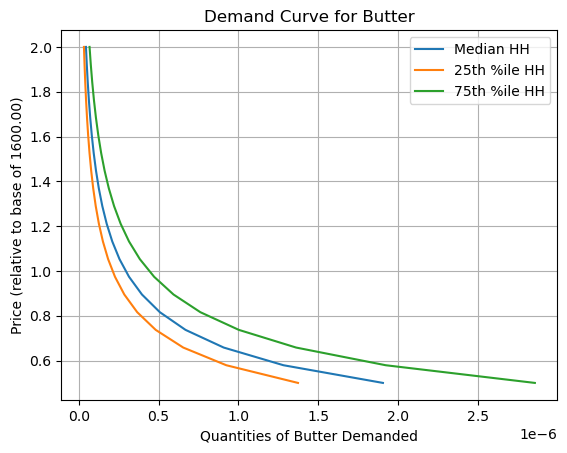

In [34]:
import matplotlib.pyplot as plt
import numpy as np

#Step 1: Get average price per good from the data
pbar_full = p.mean(axis=1)  # Average across markets

#Step 2: Reindex to match the order of goods used in the regression model
goods = result.beta.index  # This is the correct good order expected by the model
pbar = pbar_full.reindex(goods)  # Align price vector to match model order

#Step 3: Fill any missing prices with 1 (to avoid errors)
pbar = pbar.fillna(1)

#Step 4: Choose a good from the list (make sure it's in result.beta.index)
print("Available goods:", list(pbar.index))
use = 'Butter'  # Replace with another valid good if needed

#Step 5: Define a safe price-change function
def my_prices(p0, j, p=pbar):
    p = p.copy()
    p.loc[j] = p0
    return p

#Step 6: Plot demand curve
scale = np.linspace(0.5, 2, 20)

#Demand at median budget
plt.plot(
    [result.demands(xref, my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='Median HH'
)

#25th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='25th %ile HH'
)

#75th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='75th %ile HH'
)

#Step 7: Final plot formatting
plt.xlabel(f"Quantities of {use} Demanded")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.title(f"Demand Curve for {use}")
plt.legend()
plt.grid(True)
plt.show()

##### Engel Curves



Engel curves trace out how demand changes with budget:



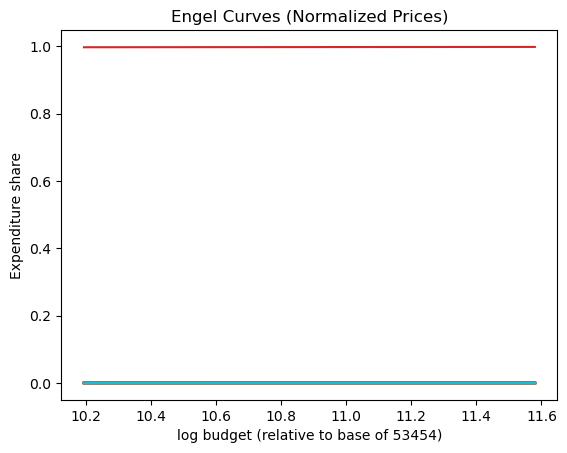

In [29]:
# Step 1: Normalize reference prices so their average is 1
pbar_normalized = pbar / pbar.mean()

# Step 2: Recalculate Engel curves with normalized pbar
fig, ax = plt.subplots()

ax.plot(
    np.log(scale * xref),
    [result.expenditures(s * xref, pbar_normalized) / (s * xref) for s in scale]
)

ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Normalized Prices)")

plt.show()

In [30]:
# Expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref
shares.sort_values(ascending=False).head(10)

j
Soybean/vegetable oil (Ninaal, Jaara, etc.)            0.975487
Chocolate bars/spreads                                 0.010623
Mayonnaise                                             0.003768
Chicken meat                                           0.003622
Eggs                                                   0.001062
Beef                                                   0.000825
Millet                                                 0.000617
Fruit juices (orange, bissap, ginger, cashew, etc.)    0.000564
Shelled or pounded peanuts (noflaye)                   0.000548
Pasta                                                  0.000437
Name: quantities, dtype: float64

Engel Curve of Top 5 Non-Dominant Goods (exclude Huile de soja / végétale):

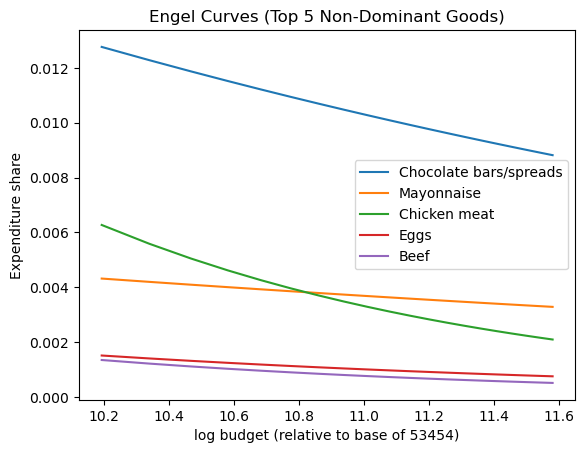

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import consumerdemands._core as core

# Loosen solver tolerance to avoid convergence issues
core.default_solver_tolerance = 1e-8

# Step 1: Define scale
scale = np.linspace(0.5, 2, 20)

# Step 2: Calculate expenditure shares
shares = result.expenditures(xref, pbar) / xref
dominant_good = shares.sort_values(ascending=False).index[0]
top_goods = shares.drop(dominant_good).sort_values(ascending=False).head(5).index

# Step 3: Compute Engel curves using full price vector
fig, ax = plt.subplots()

for g in top_goods:
    share_curve = []
    for s in scale:
        try:
            demands = result.demands(s * xref, pbar)
            share = demands[g] * pbar[g] / (s * xref)
            share_curve.append(share)
        except Exception as e:
            print(f"Skipped {g} at scale {s} due to error: {e}")
            share_curve.append(np.nan)
    
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 4: Plot formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Top 5 Non-Dominant Goods)")
ax.legend()
plt.show()

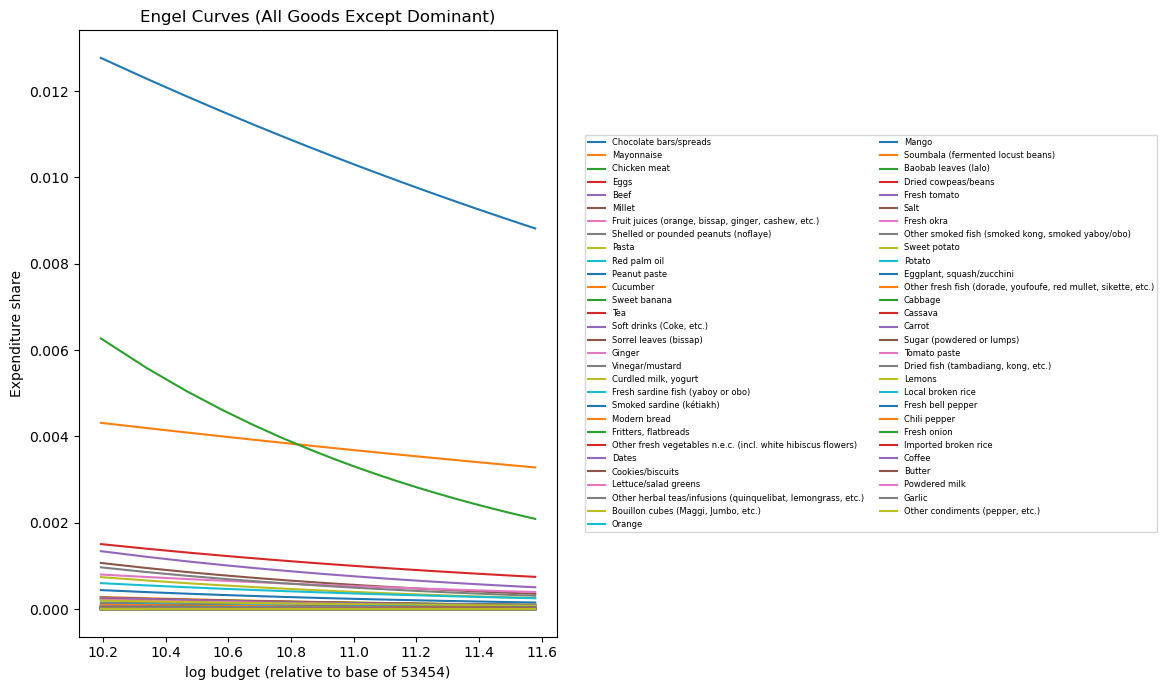

In [32]:
# Step 1: Compute expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref

# Step 2: Drop dominant good (the one with the highest share)
shares_no_dominant = shares.sort_values(ascending=False).iloc[1:]
goods_to_plot = shares_no_dominant.index

# Step 3: Budget scaling range
scale = np.linspace(0.5, 2, 20)

# Step 4: Plot Engel curves
fig, ax = plt.subplots(figsize=(12, 7))

for g in goods_to_plot:
    share_curve = [
        result.demands(s * xref, pbar)[g] * pbar[g] / (s * xref)
        for s in scale
    ]
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 5: Labels, legend, formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (All Goods Except Dominant)")
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.tight_layout()
plt.show()

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



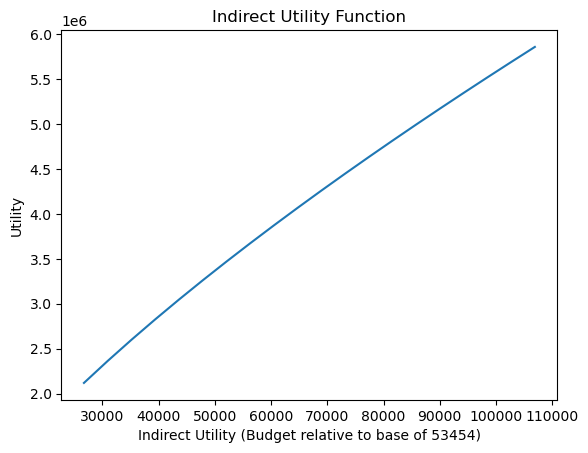

In [33]:
# Plot the indirect utility function over scaled budgets
fig, ax = plt.subplots()

# Compute utility values for different scaled budgets
utilities = [result.indirect_utility(s * xref, pbar) for s in scale]

# Plot
ax.plot(scale * xref, utilities)
ax.set_xlabel(f"Indirect Utility (Budget relative to base of {xref:.0f})")
ax.set_ylabel("Utility")
ax.set_title("Indirect Utility Function")
plt.show()

# Nutritional Analysis of Diet

In [36]:
fct = pd.read_csv("FCT.csv", index_col = 0)
fct.head()

,j,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
0,Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
1,Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
2,Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
3,Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
4,Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [46]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expend = get_clean_sheet('Food_Expenditures_T(2019).csv')
expend

,i,t,m,j,Expenditure
0,21001,2019,ziguinchor,Garlic,25.0
1,21001,2019,ziguinchor,Butter,75.0
2,21001,2019,ziguinchor,Coffee,75.0
3,21001,2019,ziguinchor,Carrot,100.0
4,21001,2019,ziguinchor,Cabbage,50.0
...,...,...,...,...,...
93744,2989,2019,ziguinchor,Sugar (powdered or lumps),500.0
93745,2989,2019,ziguinchor,Tea,100.0
93746,2989,2019,ziguinchor,Fresh tomato,100.0
93747,2989,2019,ziguinchor,Beef,1200.0


In [100]:


def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
expend = get_clean_sheet('Food_Expenditures_T(2019).csv')
exp = get_clean_sheet('Food_Expenditures_T(2019).csv')

exp_wide = expend.pivot_table(
    index=["i", "t", "m"],   # The keys identifying each row
    columns="j",            # The column you want to spread out
    values="Expenditure",   # What goes in the cells
    aggfunc="sum",          # How to aggregate if you have repeats
)

# If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
expend = exp_wide.reset_index()

if 'm' not in expend.columns:
    expend['m'] = 1

expend = expend.set_index(['i','t','m'])
expend.columns.name = 'j'

expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
expend = expend.replace(0,np.nan)

# Get HH characteristics...
hhc = get_clean_sheet('Household_Characteristics.csv')

if 'm' not in hhc.columns:
    hhc['m'] = 1

hhc = hhc.set_index(['i','t','m'])
hhc.columns.name = 'k'

hhc = hhc.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet('Food_Prices_T(2019).csv')

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet('FCT.csv')

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet('RDI.csv')
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

In [129]:
# If your CSV has columns [t, m, j, Price] in long form:
p = pd.read_csv("Food_Prices_T(2019).csv")

# Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")

# Convert to numeric if needed
p["Price"] = pd.to_numeric(p["Price"], errors="coerce")

# Pivot so each unique `j` becomes a column and
# each (t, m) is one row
p_wide = p.pivot_table(
    index=["t","m"],
    columns="j",
    values="Price",
    aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
) #.reset_index()

p_wide.columns.name = None  # remove the pivoted index name if desired

p = p_wide #.set_index('t')


In [130]:
p

Attiéké (cassava couscous)  Avocados  Baby milk and cereals  \
t    m                                                                          
2019 SAINT-LOUIS                         NaN       NaN             983.333333   
     dakar                             922.5     650.0            1837.500000   
     diourbel                            NaN       NaN            1600.000000   
     fatick                              NaN       NaN             600.000000   
     kaffrine                            NaN       NaN            1850.000000   
     kaolack                             NaN       NaN            3000.000000   
     kedougou                          500.0     412.5            1741.666667   
     kolda                             250.0    2000.0            1100.000000   
     louga                               NaN       NaN            2016.666667   
     matam                               NaN       NaN            1000.000000   
     sedhiou                             NaN       NaN            1081.250000   
     tambacounda                         NaN       NaN            1650.000000   
     thies                               NaN       NaN            2050.000000   
     ziguinchor                        500.0     250.0            2500.000000   

                  Baobab leaves (lalo)  Bean/cowpea leaves    Beef  \
t    m                                                               
2019 SAINT-LOUIS             50.000000          166.666667  3750.0   
     dakar                   50.000000          225.000000  3000.0   
     diourbel              1266.666667                 NaN  2650.0   
     fatick                 583.333333                 NaN  2500.0   
     kaffrine              1025.000000           75.000000  1850.0   
     kaolack               1145.833252                 NaN  2500.0   
     kedougou                62.500000          106.250000  1575.0   
     kolda                  537.500000                 NaN  2000.0   
     louga                  566.666667          100.000000  2500.0   
     matam                  275.000000          127.083333  1400.0   
     sedhiou                 87.500000          100.000000  1625.0   
     tambacounda            416.666667          225.000000  1800.0   
     thies                  183.333333          100.000000  3150.0   
     ziguinchor             100.000000                 NaN  2125.0   

                  Bouillon cubes (Maggi, Jumbo, etc.)       Butter  \
t    m                                                               
2019 SAINT-LOUIS                            25.000000   543.750000   
     dakar                                  25.000000   808.333333   
     diourbel                               62.500000   625.000000   
     fatick                                 62.500000   366.071429   
     kaffrine                               62.500000   864.285714   
     kaolack                                62.500000   395.833333   
     kedougou                               25.000000   361.904762   
     kolda                                  62.500000   715.625000   
     louga                                  25.000000   475.000000   
     matam                                  25.000000   695.000000   
     sedhiou                                25.000000  1003.571429   
     tambacounda                           416.666667  1217.857143   
     thies                                  25.000000   371.428571   
     ziguinchor                             25.000000   732.142857   

                     Cabbage        Cakes  ...          Tea  Tomato paste  \
t    m                                     ...                              
2019 SAINT-LOUIS  375.000000   500.000000  ...   894.791667    587.500000   
     dakar        304.166667  5166.666667  ...  1368.750000    850.000000   
     diourbel     325.000000          NaN  ...   893.750000    701.041667   
     fatick       181.250000   250.000000  ...   100.000000    780.208333   
     kaffrine    

In [131]:

result = cfe.Regression(y=np.log(expend.stack()),d=hhc)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Soybean/vegetable oil (Ninaal, Jaara, etc.)                       3.504770
Imported broken rice                                              3.313101
Local broken rice                                                 3.001446
Powdered milk                                                     2.927623
Mayonnaise                                                        2.781109
Butter                                                            2.700641
Fresh onion                                                       2.647659
Coffee                                                            2.579637
Chocolate bars/spreads                                            2.539853
Vinegar/mustard                                                   2.502569
Garlic                                                            2.379389
Sugar (powdered or lumps)                                         2.274736
Other condiments (pepper, etc.)                                   2.260853
Other fresh fish (dorad

In [132]:
xhat.unstack('j')

,,j,Baobab leaves (lalo),Beef,"Bouillon cubes (Maggi, Jumbo, etc.)",Butter,Cabbage,Carrot,Cassava,Chicken meat,Chili pepper,Chocolate bars/spreads,...,"Soft drinks (Coke, etc.)",Sorrel leaves (bissap),Soumbala (fermented locust beans),"Soybean/vegetable oil (Ninaal, Jaara, etc.)",Sugar (powdered or lumps),Sweet banana,Sweet potato,Tea,Tomato paste,Vinegar/mustard
i,t,m,,,,,,,,,,,,,,,,,,,,,
221,2019,dakar,107.077774,3490.727220,99.763717,405.592457,229.066960,189.589034,176.200331,5475.275276,119.614876,1196.221214,...,1350.284643,156.327226,83.768318,4114.798822,820.858268,611.161751,156.504354,227.000019,569.788423,229.531455
222,2019,dakar,76.961061,2473.290620,87.963137,509.709071,186.413695,148.398081,148.296397,3567.108092,121.230558,753.934059,...,1072.311641,114.143018,81.643013,3002.929969,815.170057,510.426996,136.295529,206.735985,317.597567,219.819719
223,2019,dakar,57.781976,1550.050993,47.387602,130.137181,89.017769,72.018149,71.561981,2133.123192,55.305285,470.868410,...,473.836276,90.666720,54.934887,751.670734,283.569021,346.526070,72.043542,124.062388,194.350387,91.083812
224,2019,dakar,63.393516,2791.406647,94.407804,573.485177,216.760710,176.728404,158.694581,3451.914177,146.960941,1284.867227,...,1069.655007,117.802220,94.947489,4349.174731,940.310922,551.613719,145.910210,202.460063,473.169904,312.433921
226,2019,dakar,84.792200,2530.631797,101.948786,528.998416,202.698460,166.381097,145.271109,3351.554002,136.622824,1426.011353,...,928.217407,119.250199,98.267607,3917.832106,882.205840,517.708932,138.305964,198.676261,448.209669,303.279716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259410,2019,sedhiou,79.367088,3138.067650,79.591770,1231.463625,147.654905,145.125504,122.865918,4712.555343,62.205515,1285.690880,...,739.771855,79.833755,71.722153,1785.096632,781.130869,296.599009,137.924620,163.896630,184.358588,262.154896
259612,2019,sedhiou,81.893759,3466.799945,106.194700,1927.295460,174.192589,162.313858,171.699652,5441.006087,69.090206,717.815247,...,927.545905,96.656720,85.475977,2292.902635,977.480642,250.969881,147.861435,141.049199,199.025406,240.396086
259810,2019,sedhiou,57.821584,2431.517247,49.639097,632.396395,96.625800,92.652586,78.304629,3955.417715,40.126898,569.880725,...,634.749571,64.302263,50.690774,693.692966,442.514987,224.779120,95.235879,129.118518,113.693879,129.558073


In [133]:
p

Attiéké (cassava couscous)  Avocados  Baby milk and cereals  \
t    m                                                                          
2019 SAINT-LOUIS                         NaN       NaN             983.333333   
     dakar                             922.5     650.0            1837.500000   
     diourbel                            NaN       NaN            1600.000000   
     fatick                              NaN       NaN             600.000000   
     kaffrine                            NaN       NaN            1850.000000   
     kaolack                             NaN       NaN            3000.000000   
     kedougou                          500.0     412.5            1741.666667   
     kolda                             250.0    2000.0            1100.000000   
     louga                               NaN       NaN            2016.666667   
     matam                               NaN       NaN            1000.000000   
     sedhiou                             NaN       NaN            1081.250000   
     tambacounda                         NaN       NaN            1650.000000   
     thies                               NaN       NaN            2050.000000   
     ziguinchor                        500.0     250.0            2500.000000   

                  Baobab leaves (lalo)  Bean/cowpea leaves    Beef  \
t    m                                                               
2019 SAINT-LOUIS             50.000000          166.666667  3750.0   
     dakar                   50.000000          225.000000  3000.0   
     diourbel              1266.666667                 NaN  2650.0   
     fatick                 583.333333                 NaN  2500.0   
     kaffrine              1025.000000           75.000000  1850.0   
     kaolack               1145.833252                 NaN  2500.0   
     kedougou                62.500000          106.250000  1575.0   
     kolda                  537.500000                 NaN  2000.0   
     louga                  566.666667          100.000000  2500.0   
     matam                  275.000000          127.083333  1400.0   
     sedhiou                 87.500000          100.000000  1625.0   
     tambacounda            416.666667          225.000000  1800.0   
     thies                  183.333333          100.000000  3150.0   
     ziguinchor             100.000000                 NaN  2125.0   

                  Bouillon cubes (Maggi, Jumbo, etc.)       Butter  \
t    m                                                               
2019 SAINT-LOUIS                            25.000000   543.750000   
     dakar                                  25.000000   808.333333   
     diourbel                               62.500000   625.000000   
     fatick                                 62.500000   366.071429   
     kaffrine                               62.500000   864.285714   
     kaolack                                62.500000   395.833333   
     kedougou                               25.000000   361.904762   
     kolda                                  62.500000   715.625000   
     louga                                  25.000000   475.000000   
     matam                                  25.000000   695.000000   
     sedhiou                                25.000000  1003.571429   
     tambacounda                           416.666667  1217.857143   
     thies                                  25.000000   371.428571   
     ziguinchor                             25.000000   732.142857   

                     Cabbage        Cakes  ...          Tea  Tomato paste  \
t    m                                     ...                              
2019 SAINT-LOUIS  375.000000   500.000000  ...   894.791667    587.500000   
     dakar        304.166667  5166.666667  ...  1368.750000    850.000000   
     diourbel     325.000000          NaN  ...   893.750000    701.041667   
     fatick       181.250000   250.000000  ...   100.000000    780.208333   
     kaffrine    

In [134]:
result.to_pickle('./foo.pickle')


result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')


# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]



In [135]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)
nutrients

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
21741,2019,SAINT-LOUIS,6634.600900,292.082681,107.977799,1220.138467,593.565571,900.988977,55.493736,74.491511,6.368451,5.988580,559.199802,21.723752,8.933567,42.781623,47.132583
21742,2019,SAINT-LOUIS,8958.066213,354.650701,166.033124,1764.155546,667.313930,1373.575357,74.064603,103.302797,8.174101,8.674870,561.960636,20.291400,11.379725,47.069252,56.366898
21743,2019,SAINT-LOUIS,7656.779823,327.402166,129.116251,1417.942768,609.443301,1072.031976,63.469737,87.472718,7.089625,7.023065,542.702952,23.316547,10.042317,42.626177,53.225516
21744,2019,SAINT-LOUIS,10931.914548,446.559097,195.799696,2120.106296,939.098774,1629.764236,91.086403,124.208506,10.234579,10.423639,792.378294,27.427275,14.480497,72.477829,70.887192
21745,2019,SAINT-LOUIS,7573.718647,340.966612,119.182237,1359.736686,730.146535,999.864904,63.517653,84.524110,7.299687,6.730257,656.802981,26.534971,10.540124,56.742685,55.392062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212110,2019,ziguinchor,24456.334581,1179.363725,308.809105,2398.973856,13688.560462,3709.074401,235.647249,205.795229,21.523164,24.646357,1432.463434,75.484918,104.430354,2214.526417,207.688759
212111,2019,ziguinchor,18085.657643,904.364264,214.282863,1801.531546,8901.908220,2510.057601,170.612989,159.514097,16.017897,17.202658,1134.288213,67.719482,70.068724,1417.633416,160.065872
212112,2019,ziguinchor,8979.155930,398.116221,137.646937,1317.465556,1622.220287,1242.949259,75.329845,100.751073,7.141888,8.237944,230.584673,30.623804,18.474269,233.891890,70.462308


In [136]:
rdi.columns.tolist()

['F 00-03',
 'M 00-03',
 'F 04-08',
 'M 04-08',
 'F 09-13',
 'M 09-13',
 'F 14-18',
 'M 14-18',
 'F 19-30',
 'M 19-30',
 'F 31-50',
 'M 31-50',
 'F 51+',
 'M 51+']

In [137]:
hhc.columns = hhc.columns.str.replace("Females", "F").str.replace("Males", "M")
hhc.columns = hhc.columns.str.replace("51-99", "51+")
#hhc.columns = df.columns.str.replace("M 51-99", "M 51+")
hhc

,,k,women,girls,boys,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2019,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000
2986,2019,ziguinchor,5,5,1,1,0,0,0,2,1,0,0,4,0,3,0,1,1,0,2.484907
2987,2019,ziguinchor,1,0,2,4,0,0,1,0,1,0,0,0,3,0,0,1,1,0,1.945910


In [138]:
hhc = hhc[rdi.columns.tolist()]

hh_rdi = hhc@rdi.T 
#z = # ppl in household , rdi => add up all ppl in household

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

hh_rwi

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,14000.0,392.0,196.0,2800.0,7000.0,910.0,56.0,2940.0,112.0,4900.0,32900.0,9.1,8.4,6300.0,16.8,11.9,630.0,105.0,840.0,77.0
110110,2018,ziguinchor,54600.0,1274.0,764.4,10500.0,32200.0,3640.0,343.0,9240.0,392.0,27300.0,130200.0,30.1,29.4,20300.0,63.0,33.6,1925.0,392.0,2415.0,252.0
110111,2018,ziguinchor,63000.0,1512.0,882.0,11200.0,32200.0,3640.0,266.0,11480.0,448.0,27300.0,131600.0,36.4,33.6,25200.0,67.2,36.4,2310.0,420.0,2730.0,308.0
110112,2018,ziguinchor,23800.0,644.0,333.2,5600.0,17500.0,1820.0,161.0,4760.0,196.0,13650.0,65800.0,14.7,14.7,9800.0,33.6,18.9,980.0,210.0,1155.0,119.0
11012,2018,ziguinchor,130200.0,3045.0,1822.8,25200.0,80500.0,9100.0,833.0,22330.0,952.0,66850.0,319900.0,73.5,71.4,49700.0,151.2,83.3,4550.0,938.0,5740.0,616.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2019,ziguinchor,15400.0,392.0,215.6,2800.0,7000.0,910.0,56.0,2940.0,112.0,4900.0,32900.0,9.1,8.4,6300.0,16.8,9.1,630.0,105.0,840.0,77.0
2986,2019,ziguinchor,148400.0,3472.0,2077.6,30100.0,94500.0,10920.0,1176.0,25270.0,1092.0,75250.0,380800.0,82.6,81.9,55300.0,180.6,97.3,5215.0,1120.0,6650.0,679.0
2987,2019,ziguinchor,99400.0,2261.0,1391.6,17500.0,51100.0,6370.0,476.0,16170.0,686.0,36750.0,222600.0,54.6,51.8,37100.0,105.0,59.5,3535.0,651.0,4795.0,455.0


In [139]:
nutrients

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
21741,2019,SAINT-LOUIS,6634.600900,292.082681,107.977799,1220.138467,593.565571,900.988977,55.493736,74.491511,6.368451,5.988580,559.199802,21.723752,8.933567,42.781623,47.132583
21742,2019,SAINT-LOUIS,8958.066213,354.650701,166.033124,1764.155546,667.313930,1373.575357,74.064603,103.302797,8.174101,8.674870,561.960636,20.291400,11.379725,47.069252,56.366898
21743,2019,SAINT-LOUIS,7656.779823,327.402166,129.116251,1417.942768,609.443301,1072.031976,63.469737,87.472718,7.089625,7.023065,542.702952,23.316547,10.042317,42.626177,53.225516
21744,2019,SAINT-LOUIS,10931.914548,446.559097,195.799696,2120.106296,939.098774,1629.764236,91.086403,124.208506,10.234579,10.423639,792.378294,27.427275,14.480497,72.477829,70.887192
21745,2019,SAINT-LOUIS,7573.718647,340.966612,119.182237,1359.736686,730.146535,999.864904,63.517653,84.524110,7.299687,6.730257,656.802981,26.534971,10.540124,56.742685,55.392062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212110,2019,ziguinchor,24456.334581,1179.363725,308.809105,2398.973856,13688.560462,3709.074401,235.647249,205.795229,21.523164,24.646357,1432.463434,75.484918,104.430354,2214.526417,207.688759
212111,2019,ziguinchor,18085.657643,904.364264,214.282863,1801.531546,8901.908220,2510.057601,170.612989,159.514097,16.017897,17.202658,1134.288213,67.719482,70.068724,1417.633416,160.065872
212112,2019,ziguinchor,8979.155930,398.116221,137.646937,1317.465556,1622.220287,1242.949259,75.329845,100.751073,7.141888,8.237944,230.584673,30.623804,18.474269,233.891890,70.462308


In [140]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
221,2019,dakar,0.089215,0.180523,0.087234,0.080417,0.020214,0.146532,0.139794,0.123685,0.168399,0.132191,0.032344,0.321746,0.191999,0.024056,0.145084
222,2019,dakar,0.163998,0.376760,0.178473,0.173707,0.033243,0.251284,0.215207,0.245202,0.333940,0.273273,0.063669,0.539364,0.420422,0.057759,0.269229
223,2019,dakar,0.166762,0.301737,0.211357,0.163943,0.019976,0.330153,0.232399,0.253217,0.281569,0.276080,0.037369,0.360526,0.310698,0.025767,0.236558
224,2019,dakar,0.261041,0.535962,0.264059,0.253026,0.086755,0.511047,0.326705,0.365736,0.544293,0.412074,0.117302,0.878815,0.662205,0.093173,0.442840
226,2019,dakar,0.329838,0.687013,0.364318,0.314941,0.072529,0.560630,0.399912,0.473968,0.652307,0.529365,0.127387,0.932573,0.739024,0.113585,0.552442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259410,2019,sedhiou,0.456466,0.879439,0.345942,0.288119,0.095334,0.586393,0.870913,0.590348,0.679067,0.528169,0.109644,1.997756,0.833596,0.114488,0.809311
259612,2019,sedhiou,0.096657,0.236869,0.091471,0.081508,0.013377,0.124092,0.117912,0.157329,0.161995,0.144558,0.020053,0.417385,0.232391,0.024401,0.195362
259810,2019,sedhiou,0.338000,0.668352,0.273331,0.228586,0.065096,0.477070,0.411771,0.476676,0.504988,0.418988,0.070712,1.504198,0.643256,0.062746,0.621977


<Axes: >

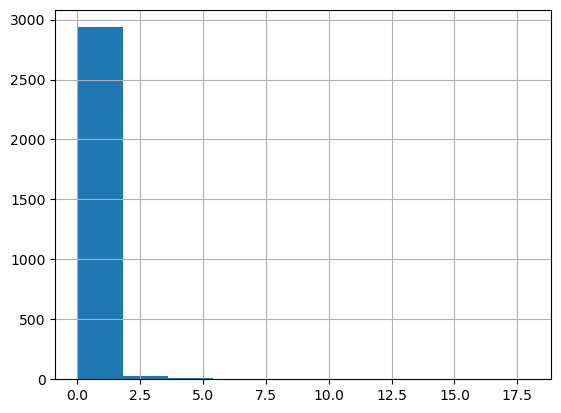

In [142]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=10)

In [ ]:
#household with 3+ adults

In [ ]:
#household with 1-2 children, 1 adult